# Parameter-Efficient Fine-Tuning with LoRA

This notebook demonstrates how to use **LoRA (Low-Rank Adaptation)** to fine-tune a pretrained GPT-2 model efficiently. LoRA reduces memory usage and computational costs by freezing most model parameters and training small, low-rank matrices.

## Introduction

Fine-tuning large language models (LLMs) can be computationally expensive and memory-intensive, especially for practitioners with limited hardware resources. **LoRA (Low-Rank Adaptation)** provides a solution by freezing most of the model's parameters and introducing trainable, low-rank matrices to adapt the model for new tasks.

This notebook walks you through the process of applying LoRA to a pretrained GPT-2 model for fine-tuning on a small dataset. By the end of this tutorial, you will:
- Understand how LoRA modifies the model architecture.
- Fine-tune a GPT-2 model using LoRA.
- Tokenize and preprocess datasets for efficient training.
- Visualize the training loss to evaluate the process.


## Prerequisites

To get the most out of this notebook, you should have:
- A basic understanding of machine learning concepts.
- Familiarity with **transformers** library by Hugging Face.
- Experience working with large language models and fine-tuning techniques.

Additionally, ensure you have access to a GPU-enabled environment, as fine-tuning large models requires substantial computational resources.

In [31]:
# Install required libraries
# !pip install transformers datasets peft matplotlib 

## Step 1: Load Pretrained GPT-2 Model and Tokenizer

In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load GPT-2 model and tokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2") # Load GPT-2 model with causal language modeling head
tokenizer = AutoTokenizer.from_pretrained("gpt2") # Load GPT-2 tokenizer

# Set an existing token (e.g., eos_token) as the padding token (The GPT-2 tokenizer already has an eos_token (End of Sequence) that can serve as a padding token)
tokenizer.pad_token = tokenizer.eos_token # Set the padding token to be the eos_token

# Print model summary
print("Model loaded successfully!")

Model loaded successfully!


## Step 2: Apply LoRA Configuration to the Model

In [33]:
from peft import LoraConfig, get_peft_model # Import LoRA configuration and function to apply LoRA to the model from PEFT library

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,            # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["c_attn", "c_proj"],  # Target attention layers
    lora_dropout=0.1, # Dropout rate
    fan_in_fan_out=True  # Set this explicitly for Conv1D ensures compatibility with their specific architecture.
) 

# Apply LoRA to the model
model = get_peft_model(model, lora_config) 

# Print confirmation
print("LoRA applied successfully!")

LoRA applied successfully!


## Step 3: Load and Tokenize Dataset

In [34]:
from datasets import load_dataset

# Load a small dataset (e.g., WikiText)
dataset = load_dataset('wikitext', 'wikitext-2-v1', split='train[:1%]') # Load 1% of the WikiText-2 dataset

# # Set an existing token (e.g., eos_token) as the padding token (The GPT-2 tokenizer already has an eos_token (End of Sequence) that can serve as a padding token)
# tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Convert tokenized dataset to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Print confirmation
print("Dataset tokenized successfully!")

Dataset tokenized successfully!


## Step 4: Fine-Tune the Model 

In [35]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

# Prepare data loader
data_loader = DataLoader(tokenized_dataset, batch_size=4)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Initialize an empty list to store loss values
losses = []

# Training loop
for epoch in range(1):
    print(f"Starting epoch {epoch + 1}")
    for batch in data_loader:
        inputs = batch["input_ids"].to(model.device)
        labels = inputs.clone()
        
        # Forward pass
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f"Loss: {loss.item()}")
    print(f"Epoch {epoch + 1} completed!")



Starting epoch 1
Loss: 11.213605880737305
Loss: 9.260429382324219
Loss: 7.136002063751221
Loss: 11.078072547912598
Loss: 8.75053882598877
Loss: 7.989888668060303
Loss: 10.361249923706055
Loss: 8.396666526794434
Loss: 10.872241020202637
Loss: 6.542841911315918
Loss: 10.191031455993652
Loss: 7.389627456665039
Loss: 8.499870300292969
Loss: 6.893536567687988
Loss: 7.437653541564941
Loss: 6.445542812347412
Loss: 6.254607677459717
Loss: 8.103507995605469
Loss: 7.201683044433594
Loss: 7.105834484100342
Loss: 5.628706455230713
Loss: 5.0148091316223145
Loss: 4.499671459197998
Loss: 5.394765853881836
Loss: 3.9969675540924072
Loss: 3.524667978286743
Loss: 2.9815011024475098
Loss: 3.4963691234588623
Loss: 2.848078966140747
Loss: 2.649474859237671
Loss: 2.605923891067505
Loss: 1.653231143951416
Loss: 2.745997190475464
Loss: 1.5725406408309937
Loss: 2.584290027618408
Loss: 0.4718155860900879
Loss: 2.310708522796631
Loss: 2.635611057281494
Loss: 1.3228306770324707
Loss: 1.3579076528549194
Loss: 2.527

# Plot training loss

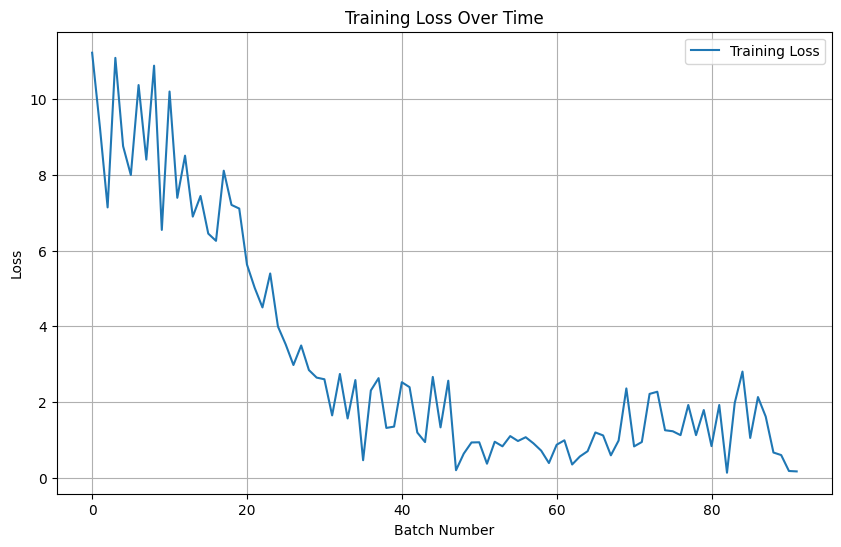

In [36]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Common Mistakes


- Make sure that all the libraries and prerequisits are installed before running this notebook


# Best Practice
- create a separated virtual environment for this lab